# Data 102 Final Project Code, Spring 2024

### Group 1: Alex Long, Cat Tseng, Tanya Saharan, Trigger Nandhra

#### Additional Datasets To Download 
***Important: READ ME***

Some of our datasets were too large to upload via Gradescope so we created a Google Drive zip for them. If there is any trouble accessing the datasets, please contact <alexlong667@berkeley.edu>.  Here is the link: https://drive.google.com/file/d/1ATKp-GVedTLjIbuel5LpaTqHw61oTViM/view

In [1]:
import numpy as np 
import pandas as pd 
from scipy.stats import ttest_ind
pd.options.mode.chained_assignment = None

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import itertools
import bambi as bmb
import arviz as az

from warnings import simplefilter
from sklearn.model_selection import train_test_split
from sklearn.exceptions import ConvergenceWarning
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

simplefilter("ignore", category=ConvergenceWarning)

import statsmodels.api as sm
from statsmodels.genmod.families import Poisson, NegativeBinomial, Gaussian, Binomial

sns.set()

import hashlib
def get_hash(num, significance = 4):
    num = round(num, significance)
    """Helper function for assessing correctness"""
    return hashlib.md5(str(num).encode()).hexdigest()

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Exploratory Data Analysis ##

In [2]:
# read csv
copd = pd.read_csv('chronic_obstructive_pulmonary_disease.csv')

In [3]:
# drop potential na data values
copd = copd.dropna(subset=['DataValue'])

# filter by the topic t0 be investigated and relevant columns
copdAdultPrev = copd[copd['Question'] == 'Mortality with chronic obstructive pulmonary disease as underlying cause among adults aged >= 45 years']

# use standardized prevalence
copdAdultPrev = copdAdultPrev[copdAdultPrev['DataValueType'] == 'Number']

# filter by relevant years
copdAdultPrev = copdAdultPrev[copdAdultPrev['YearStart'] <= 2016]

# lists representing the most urban U.S. states
# Source: https://www.newgeography.com/content/005187-america-s-most-urban-states
urbanStates = ["NJ", "CA", "NV", "MA", "FL", "HI", "RI", "UT", "AZ", "NY", "CO", "MD", "IL", "CT", "DE", "WA", "TX", "OR", "PA", "OH", "MI", "GA", "VA", "MN", "LA"]
copdAdultPrev = copdAdultPrev[copdAdultPrev['LocationAbbr'].isin(urbanStates)]

# select relevant columns
copdAdultPrev = copdAdultPrev.reset_index()
copdAdultPrev = copdAdultPrev[['YearStart', 'YearEnd', 'LocationDesc', 'Question', 'DataValueUnit', 'DataValue']]

# get average % of COPD prevalence per year
copdAdultPrev = copdAdultPrev.groupby(['LocationDesc', 'YearStart'])['DataValue'].mean()
copdAdultPrev = copdAdultPrev.reset_index()
copdAdultPrev.head()

,LocationDesc,YearStart,DataValue
0,Arizona,2010,1209.142857
1,Arizona,2011,1300.142857
2,Arizona,2012,1331.000000
3,Arizona,2013,1375.428571
4,Arizona,2014,1225.500000


In [4]:
# read csv of external dataset
# Source: https://www.kaggle.com/datasets/sogun3/uspollution?resource=download
pollution = pd.read_csv('pollution_us_2000_2016.csv')

In [5]:
# extract year from Date Local
pollution['Year'] = pollution['Date Local'].astype(str).str[:4]

# filter by relevant years
pollution = pollution[pollution['Year'].astype(int) >= 2011]

pollution = pollution[['State', 'Year', 'SO2 Mean', 'CO Mean', 'NO2 Mean', 'O3 Mean']]

avgPollutionByStateYear = pollution.groupby(['State', 'Year']).mean()
avgPollutionByStateYear = avgPollutionByStateYear.reset_index()

avgPollutionByStateYear.head()

,State,Year,SO2 Mean,CO Mean,NO2 Mean,O3 Mean
0,Alabama,2013,0.750311,0.211007,12.065635,0.012099
1,Alabama,2014,1.186517,0.205921,9.411746,0.024660
2,Alabama,2015,1.009429,0.221027,9.078580,0.024000
3,Alabama,2016,0.835118,0.209514,9.524873,0.028348
4,Alaska,2014,5.951531,0.455444,11.658510,0.010307


In [6]:
# rename columns for merging purposes
copdAdultPrev.rename(columns={'YearStart': 'Year', 'LocationDesc': 'State'}, inplace=True)

copdAdultPrev['Year'] = copdAdultPrev['Year'].astype(int)
copdAdultPrev['State'] = copdAdultPrev['State'].astype(str)

avgPollutionByStateYear['Year'] = avgPollutionByStateYear['Year'].astype(int)
avgPollutionByStateYear['State'] = avgPollutionByStateYear['State'].astype(str)

copdAdultPrevWithPollutants = copdAdultPrev.merge(avgPollutionByStateYear, on=['Year', 'State'], how='inner')

copdAdultPrevWithPollutants.rename(columns={'DataValue': 'COPDAdultMortality', 'SO2 Mean': 'SO2Mean', 'CO Mean': 'COMean', 'NO2 Mean': 'NO2Mean', 'O3 Mean': 'O3Mean'}, inplace=True)
copdAdultPrevWithPollutants.dropna()
copdAdultPrevWithPollutants.head()

,State,Year,COPDAdultMortality,SO2Mean,COMean,NO2Mean,O3Mean
0,Arizona,2011,1300.142857,0.775925,0.343425,16.615336,0.026813
1,Arizona,2012,1331.000000,0.913002,0.342598,17.831803,0.026513
2,Arizona,2013,1375.428571,0.716367,0.320892,15.479528,0.027973
3,Arizona,2014,1225.500000,0.923710,0.405268,16.112343,0.026559
4,Arizona,2015,1330.875000,0.584848,0.355645,12.704995,0.028144


### (Q1) Qualitative Visualization

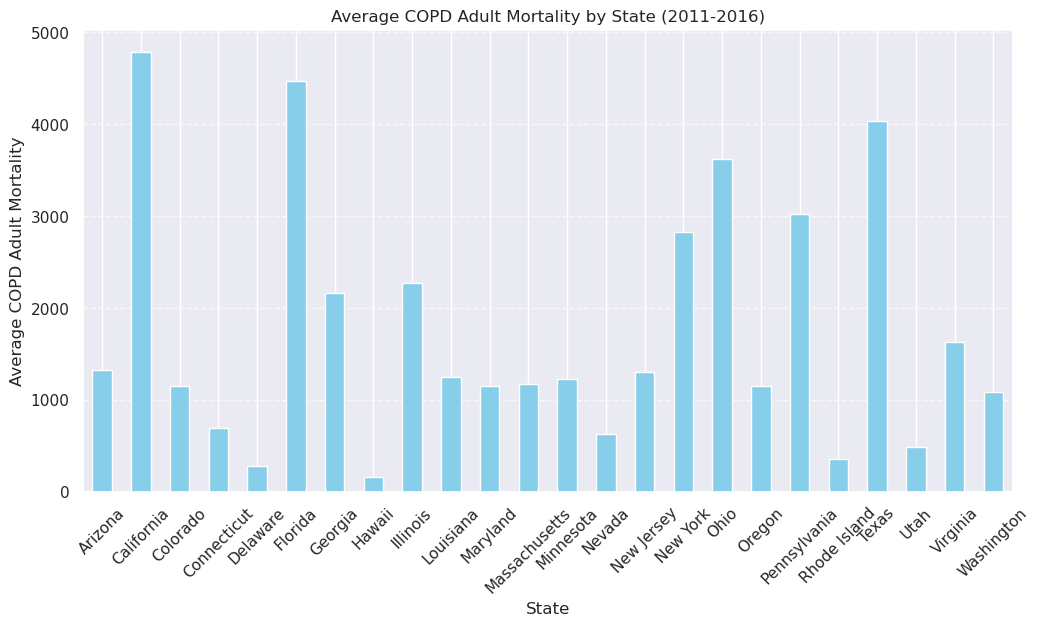

In [7]:
state_mortality = copdAdultPrevWithPollutants.groupby('State')['COPDAdultMortality'].mean()

plt.figure(figsize=(12, 6))
state_mortality.plot(kind='bar', color='skyblue')
plt.title('Average COPD Adult Mortality by State (2011-2016)')
plt.xlabel('State')
plt.ylabel('Average COPD Adult Mortality')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

### (Q1) Quantitative Visualization

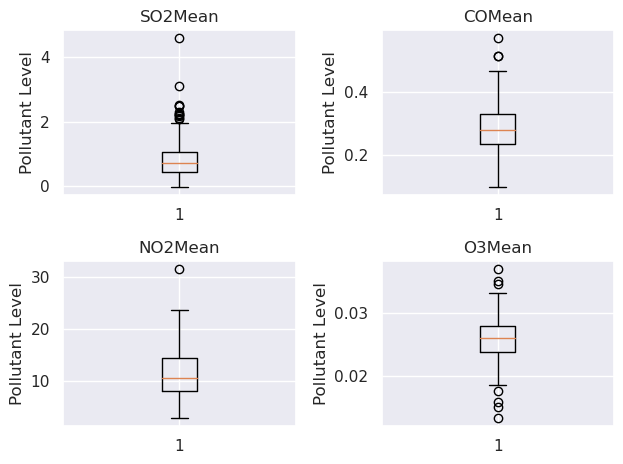

In [8]:
pollutants = ['SO2Mean', 'COMean', 'NO2Mean', 'O3Mean']

for i, pollutant in enumerate(pollutants, 1):
    plt.subplot(2, 2, i)
    plt.boxplot(copdAdultPrevWithPollutants[pollutant])
    plt.title(pollutant)
    plt.ylabel('Pollutant Level')
    
plt.tight_layout()

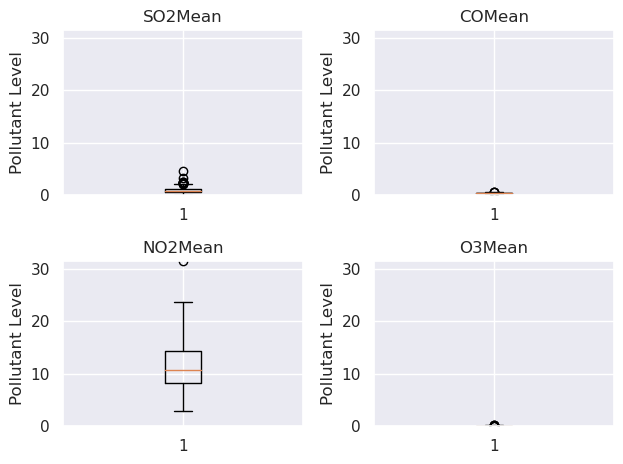

In [9]:
#The y-axes are different from each other so let's equate them.
pollutant_min = copdAdultPrevWithPollutants[pollutants].min().min()
pollutant_max = copdAdultPrevWithPollutants[pollutants].max().max()

for i, pollutant in enumerate(pollutants, 1):
    plt.subplot(2, 2, i)
    plt.boxplot(copdAdultPrevWithPollutants[pollutant])
    plt.title(pollutant)
    plt.ylim(pollutant_min, pollutant_max)  # Set the same y-axis limits for all subplots
    plt.ylabel('Pollutant Level')

plt.tight_layout()
plt.show()

### (Q2) Qualitative Visualization

In [10]:
sns.set(style="dark")
plt.style.use("ggplot")
%matplotlib inline

In [11]:
cdi = pd.read_csv('U.S._Chronic_Disease_Indicators__CDI___2023_Release.csv', low_memory = False)

In [12]:
data = cdi[cdi['YearStart']==2020][cdi['Question']=='Mortality from total cardiovascular diseases']\
[cdi['DataValueType']=='Number'][['LocationAbbr', 'Topic','DataValueUnit', 'DataValue', 'StratificationCategoryID1', 'StratificationID1']]
data = data.reset_index()

/tmp/ipykernel_467/1558627149.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = cdi[cdi['YearStart']==2020][cdi['Question']=='Mortality from total cardiovascular diseases']\
/tmp/ipykernel_467/1558627149.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = cdi[cdi['YearStart']==2020][cdi['Question']=='Mortality from total cardiovascular diseases']\


In [13]:
data.head()

,index,LocationAbbr,Topic,DataValueUnit,DataValue,StratificationCategoryID1,StratificationID1
0,1935,DC,Cardiovascular Disease,Number,894,GENDER,GENF
1,1938,HI,Cardiovascular Disease,Number,942,RACE,WHT
2,1955,ME,Cardiovascular Disease,Number,2089,GENDER,GENM
3,1958,MT,Cardiovascular Disease,Number,33,RACE,HIS
4,1971,NV,Cardiovascular Disease,Number,5319,GENDER,GENM


In [14]:
data['DataValue'] = pd.to_numeric(data['DataValue'], errors='coerce')

southern_states = ['AL', 'AR', 'DE', 'DC', 'FL', 'GA', 'KY', 'LA', 'MD', 'MS', 'NC', 'OK', 'SC', 'TN', 'TX', 'VA', 'WV']
southern_df = data[data['LocationAbbr'].isin(southern_states)]
non_southern_df = data[(~data['LocationAbbr'].isin(southern_states)) & (data['LocationAbbr'] != 'US')]

In [15]:
avg_mortality_southern = southern_df.groupby('LocationAbbr')['DataValue'].mean()
avg_mortality_non_southern = non_southern_df.groupby('LocationAbbr')['DataValue'].mean()

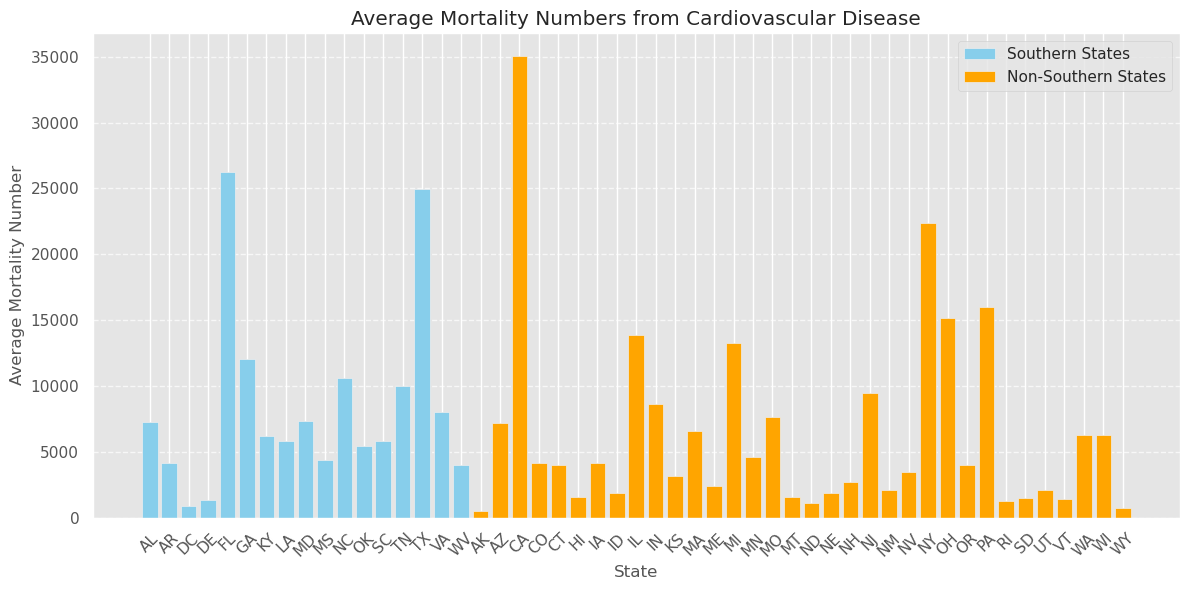

In [16]:
plt.figure(figsize=(12, 6))

plt.bar(avg_mortality_southern.index, avg_mortality_southern, color='skyblue', label='Southern States')
plt.bar(avg_mortality_non_southern.index, avg_mortality_non_southern, color='orange', label='Non-Southern States')

plt.title('Average Mortality Numbers from Cardiovascular Disease')
plt.xlabel('State')
plt.ylabel('Average Mortality Number')
plt.legend()
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### (Q2) Quantitative Visualization

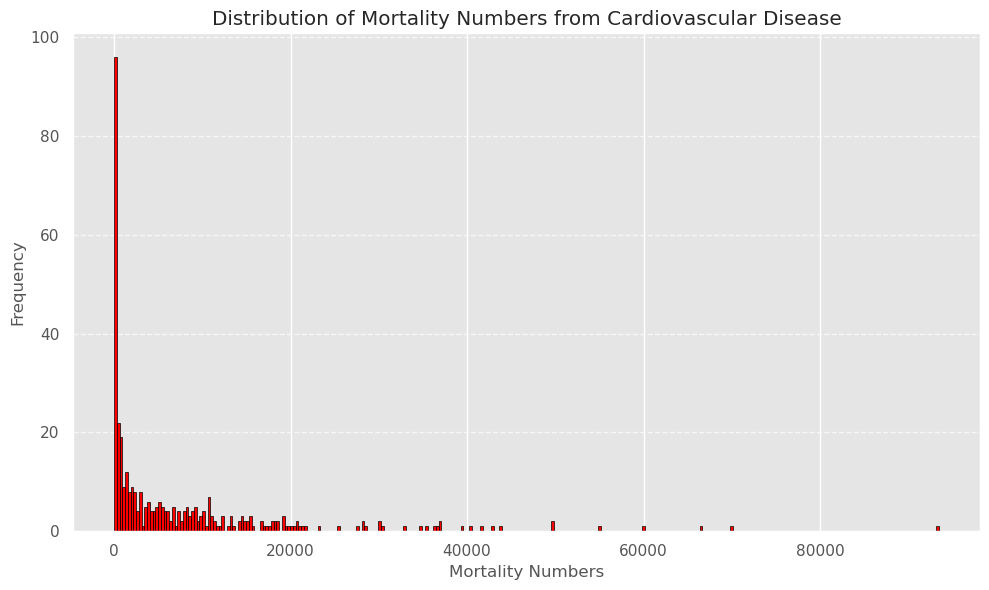

In [17]:
data['DataValue'] = pd.to_numeric(data['DataValue'], errors='coerce')
# removing the outlier again
data = data[data['LocationAbbr'] != 'US']

plt.figure(figsize=(10, 6))
plt.hist(data['DataValue'], bins=300, color='red', edgecolor='black')
plt.title('Distribution of Mortality Numbers from Cardiovascular Disease')
plt.xlabel('Mortality Numbers')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

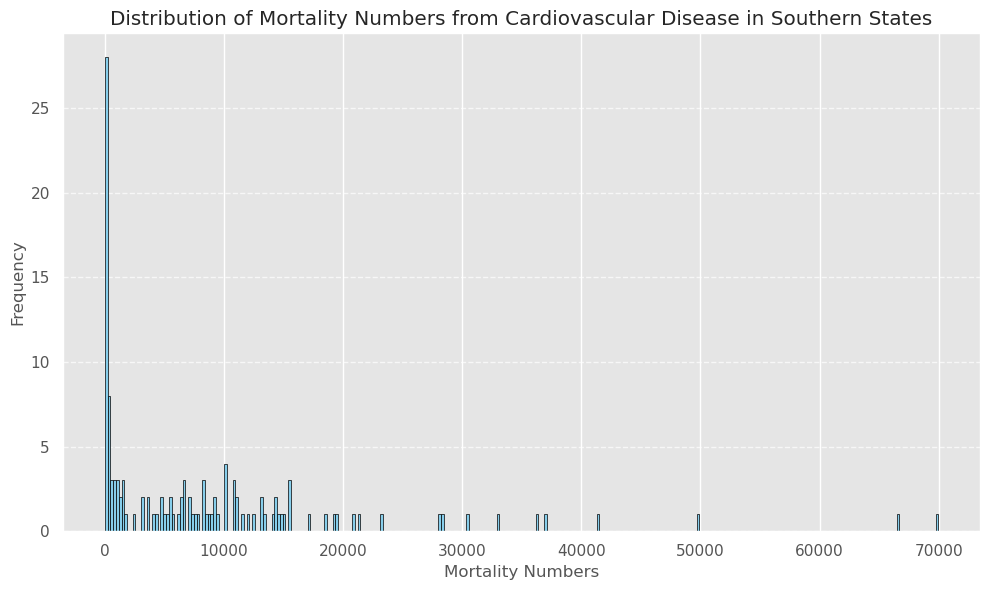

In [18]:
plt.figure(figsize=(10, 6))
plt.hist(southern_df['DataValue'], bins=300, color='skyblue', edgecolor='black')
plt.title('Distribution of Mortality Numbers from Cardiovascular Disease in Southern States')
plt.xlabel('Mortality Numbers')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

(0.0, 20000.0)

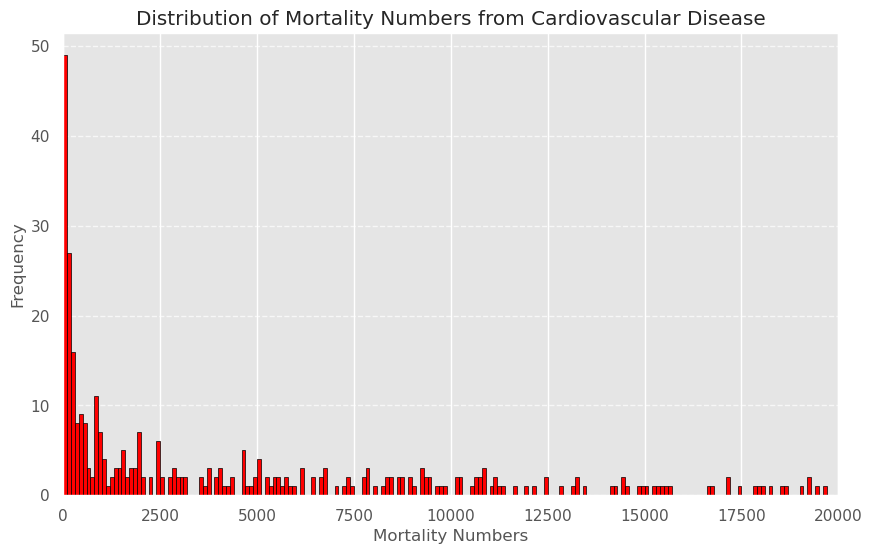

In [19]:
#Zoom into rates under 20,000 to get a better view of where most of the data takes place.
plt.figure(figsize=(10, 6))
plt.hist(data['DataValue'], bins=200, range=(0, 20000), color='red', edgecolor='black')
plt.title('Distribution of Mortality Numbers from Cardiovascular Disease')
plt.xlabel('Mortality Numbers')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlim(0, 20000)

(0.0, 2500.0)

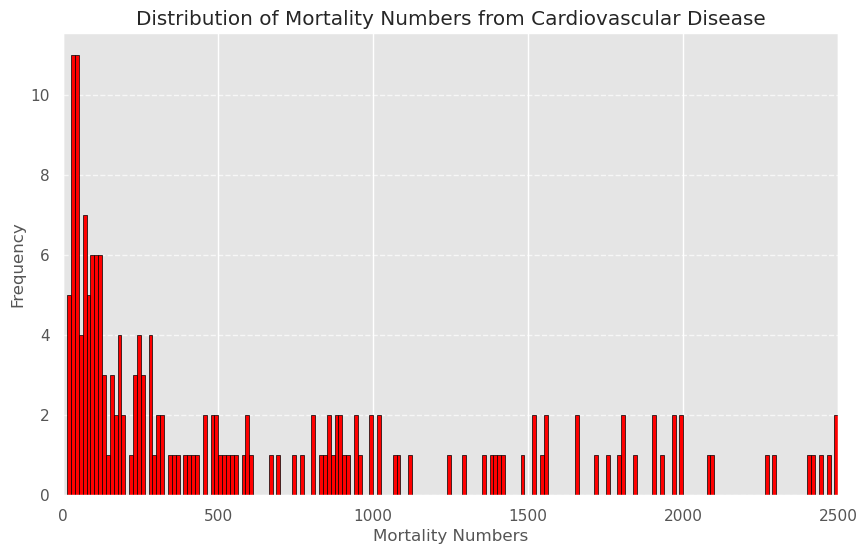

In [20]:
plt.figure(figsize=(10, 6))
plt.hist(data['DataValue'], bins=200, range=(0, 2500), color='red', edgecolor='black')  
plt.title('Distribution of Mortality Numbers from Cardiovascular Disease')
plt.xlabel('Mortality Numbers')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlim(0, 2500) 

## Research Question 1: How has the frequency of certain pollutants affect the number of mortalities caused by COPD among adults (45 and older) in more urbanized states? 

In [21]:
# separate data into features and outcome
features = copdAdultPrevWithPollutants[['SO2Mean', 'COMean', 'NO2Mean', 'O3Mean']]
outcome = copdAdultPrevWithPollutants['COPDAdultMortality']

# separate data into train and test 
# Source: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
X_train, X_test, y_train, y_test = train_test_split(features, outcome, test_size=0.33, random_state=42)

In [22]:
# Frequentist Persepective

# train models
# Source: https://www.statsmodels.org/dev/generated/statsmodels.genmod.generalized_linear_model.GLM.html
poissonModel = sm.GLM(y_train, exog = sm.add_constant(X_train), 
                  family=sm.families.Poisson())
poissonResults = poissonModel.fit()

negativeBinomialModel = sm.GLM(y_train, exog = sm.add_constant(X_train), 
                      family=sm.families.NegativeBinomial())
negativeBinomialResults = negativeBinomialModel.fit()

# since AIC for Negative Binomial is the smallest, we choose that GLM
print("Poisson AIC:", poissonResults.aic)
print("Negative Binomial AIC:", negativeBinomialResults.aic)

# test models
# Source: https://www.statsmodels.org/dev/generated/statsmodels.genmod.generalized_linear_model.GLM.html
negativeBinPred = negativeBinomialResults.predict(sm.add_constant(X_test))

# calculate MSE
# https://www.statsmodels.org/dev/generated/statsmodels.genmod.generalized_linear_model.GLM.html
freqMSE = mean_absolute_error(y_test, negativeBinPred)
print("MAE for our Frequentist Negative Binomial Model:", freqMSE)

print(negativeBinomialResults.summary())

Poisson AIC: 77948.80257355818
Negative Binomial AIC: 1564.4502146951854
MAE for our Frequentist Negative Binomial Model: 1071.042171496483
                 Generalized Linear Model Regression Results                  
Dep. Variable:     COPDAdultMortality   No. Observations:                   91
Model:                            GLM   Df Residuals:                       86
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -777.23
Date:                Tue, 07 May 2024   Deviance:                       48.482
Time:                        01:12:41   Pearson chi2:                     42.9
No. Iterations:                    11   Pseudo R-squ. (CS):            0.08232
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025    

/srv/conda/envs/notebook/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


In [23]:
# Bayesian Persepective
# Source: https://towardsdatascience.com/applied-bayesian-inference-with-pymc3-and-bambi-pt-3-d4bfb3211509

# combine the two training sets into one table
train = X_train.copy()
train['COPDAdultMortality'] = y_train.copy()

# train Bayesian Negative Binomial model
# use default priors provided by bambi
bayesianNegativeBinomialModel = bmb.Model(formula='COPDAdultMortality ~ SO2Mean + COMean + NO2Mean + O3Mean', 
                                   data=train, family='negativebinomial')

# fit Bayesian model
bayesianNegativeBinomialResults = bayesianNegativeBinomialModel.fit(random_seed=42)

resultSummary = az.summary(bayesianNegativeBinomialResults, round_to=3)
print(resultSummary)

# generate our Bayesian Negative Binomial predictions
# Source: https://towardsdatascience.com/applied-bayesian-inference-with-pymc3-and-bambi-pt-3-d4bfb3211509
bayesianNegativeBinomialModel.predict(bayesianNegativeBinomialResults, kind="pps", data=X_test)
bayesianNegativeBinomialPredictions = bayesianNegativeBinomialResults['posterior_predictive']['COPDAdultMortality'].values.mean(axis=0).mean(axis=0)

# calculate MSE
# https://www.statsmodels.org/dev/generated/statsmodels.genmod.generalized_linear_model.GLM.html
bayeMSE = mean_absolute_error(y_test, bayesianNegativeBinomialPredictions)
print("MAE for our Bayesian Negative Binomial Model:", bayeMSE)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [COPDAdultMortality_alpha, Intercept, SO2Mean, COMean, NO2Mean, O3Mean]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


                            mean      sd   hdi_3%  hdi_97%  mcse_mean  \
COMean                     1.495   0.882   -0.190    3.156      0.013   
COPDAdultMortality_alpha   1.911   0.270    1.455    2.451      0.004   
Intercept                  9.152   0.933    7.520   11.014      0.015   
NO2Mean                   -0.065   0.022   -0.107   -0.024      0.000   
O3Mean                   -58.395  28.848 -114.243   -5.981      0.467   
SO2Mean                    0.246   0.113    0.030    0.461      0.002   

                          mcse_sd  ess_bulk  ess_tail  r_hat  
COMean                      0.010  4558.777  3203.171  1.001  
COPDAdultMortality_alpha    0.003  3968.270  2924.627  1.002  
Intercept                   0.011  3833.272  3037.170  1.002  
NO2Mean                     0.000  4292.877  3163.579  1.001  
O3Mean                      0.331  3807.768  3023.319  1.001  
SO2Mean                     0.001  4253.868  2985.307  1.000  
MAE for our Bayesian Negative Binomial Model: 1

In [24]:
# nonparametric method (Random Forest)

# train our Random Forest model
randomForestModel = RandomForestRegressor(n_estimators=100, random_state=42)
randomForestModel.fit(X_train, y_train)

# generate our Random Forest model predictions
randomForestResult = randomForestModel.predict(X_test)

# calculate MSE
# https://www.statsmodels.org/dev/generated/statsmodels.genmod.generalized_linear_model.GLM.html
randomForestRSquared = r2_score(y_test, randomForestResult)
randomForestMSE = mean_absolute_error(y_test, randomForestResult)

print('R-squared for our Random Forest Nonparametric Model:', randomForestRSquared)
print('MAE for our Random Forest Nonparametric Model:', randomForestMSE)

R-squared for our Random Forest Nonparametric Model: 0.3730077747274654
MAE for our Random Forest Nonparametric Model: 694.4557873015873


## Research Question 2: What is the causal effect of living in a Southern state in 2020 on cases of mortality from cardiovascular disease?

In [25]:
def categorize(state):
    if state in ['AL', 'AR', 'DE', 'DC', 'FL', 'GA', 'KY', 'LA', 'MD', 'MS', 'NC', 'OK', 'SC', 'TN', 'TX', 'VA', 'WV']:
        return 1
    else:
        return 0

In [26]:
data['treat'] = data['LocationAbbr'].apply(categorize).astype(int)

In [27]:
ovr = data[data['StratificationCategoryID1']=='OVERALL'][data['LocationAbbr']!='US']
ovr.head()

/tmp/ipykernel_467/2172253643.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ovr = data[data['StratificationCategoryID1']=='OVERALL'][data['LocationAbbr']!='US']


,index,LocationAbbr,Topic,DataValueUnit,DataValue,StratificationCategoryID1,StratificationID1,treat
6,253343,MO,Cardiovascular Disease,Number,20386.0,OVERALL,OVR,0
8,269582,DE,Cardiovascular Disease,Number,3092.0,OVERALL,OVR,1
10,278776,WV,Cardiovascular Disease,Number,6639.0,OVERALL,OVR,1
11,282843,NV,Cardiovascular Disease,Number,9277.0,OVERALL,OVR,0
14,296192,NC,Cardiovascular Disease,Number,28284.0,OVERALL,OVR,1


In [28]:
sdo = (1/len(ovr[ovr['treat']==1]))*sum(ovr[ovr['treat']==1]['DataValue'].astype(int))-(1/len(ovr[ovr['treat']==0]))*sum(ovr[ovr['treat']==0]['DataValue'].astype(int))
sdo

5193.588235294119

In [29]:
cardio_data = data.loc[data['Topic'] == 'Cardiovascular Disease']
filtered_data = cardio_data[cardio_data['StratificationCategoryID1'] != 'OVERALL']
filtered_data['Race'] = filtered_data.apply(lambda row: row['StratificationID1'] if row['StratificationCategoryID1'] == 'RACE' else None, axis=1)
filtered_data.drop(columns=['StratificationID1', 'StratificationCategoryID1'], inplace=True)
filtered_data
race_encoded = filtered_data.dropna(subset=['Race'])
race_encoded = pd.get_dummies(race_encoded, columns=['Race'])
race_encoded[['Race_AIAN', 'Race_API', 'Race_BLK', 'Race_HIS', 'Race_WHT']] = race_encoded[['Race_AIAN', 'Race_API', 'Race_BLK', 'Race_HIS', 'Race_WHT']].astype(int)
race_encoded.drop(columns = ['Race_AIAN'], inplace = True)
race_encoded = race_encoded.dropna(subset = ['DataValue'])
race_encoded

,index,LocationAbbr,Topic,DataValueUnit,DataValue,treat,Race_API,Race_BLK,Race_HIS,Race_WHT
1,1938,HI,Cardiovascular Disease,Number,942.0,0,0,0,0,1
3,1958,MT,Cardiovascular Disease,Number,33.0,0,0,0,1,0
7,269574,AZ,Cardiovascular Disease,Number,767.0,0,0,1,0,0
9,270619,WA,Cardiovascular Disease,Number,888.0,0,1,0,0,0
13,291785,MA,Cardiovascular Disease,Number,13290.0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
392,332832,MO,Cardiovascular Disease,Number,148.0,0,1,0,0,0
393,332848,WA,Cardiovascular Disease,Number,14414.0,0,0,0,0,1
394,332856,MN,Cardiovascular Disease,Number,229.0,0,1,0,0,0
396,333033,MS,Cardiovascular Disease,Number,30.0,1,0,0,0,0


### Analysis 1: Propensity Score Matching

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors

X = race_encoded[['Race_API', 'Race_BLK', 'Race_HIS', 'Race_WHT']]
y = race_encoded['treat']

model = LogisticRegression()
model.fit(X, y)

race_encoded['propensity_score'] = model.predict_proba(X)[:, 1]

treated = race_encoded[race_encoded['treat'] == 1]
control = race_encoded[race_encoded['treat'] == 0]

nn = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(control[['propensity_score']])
distances, indices = nn.kneighbors(treated[['propensity_score']])

matched_data = treated.assign(match_index=indices.flatten())
matched_data = matched_data.merge(control, left_on='match_index', right_index=True, suffixes=('_treated', '_control'))

print(race_encoded.groupby('treat')[['Race_API', 'Race_BLK', 'Race_HIS', 'Race_WHT']].mean())

matched_data['DataValue_treated'] = pd.to_numeric(matched_data['DataValue_treated'], errors='coerce')
matched_data['DataValue_control'] = pd.to_numeric(matched_data['DataValue_control'], errors='coerce')

treated_effect = matched_data['DataValue_treated'].mean()
control_effect = matched_data['DataValue_control'].mean()
treatment_effect = treated_effect - control_effect
print(f"Estimated Treatment Effect: {treatment_effect}")

       Race_API  Race_BLK  Race_HIS  Race_WHT
treat                                        
0      0.190141  0.190141  0.204225  0.239437
1      0.200000  0.226667  0.213333  0.226667
Estimated Treatment Effect: 766.0


### Analysis 2: Inverse Propensity Scores

In [31]:
model = LogisticRegression()
model.fit(X, y)

race_encoded['propensity_score'] = model.predict_proba(X)[:, 1]
race_encoded['weights'] = 1 / race_encoded['propensity_score']

In [32]:
race_encoded['weights'] = pd.to_numeric(race_encoded['weights'], errors='coerce')
race_encoded['DataValue'] = pd.to_numeric(race_encoded['DataValue'], errors='coerce')
race_encoded.dropna(subset=['weights', 'DataValue'], inplace=True)

weighted_average_treated = (race_encoded[race_encoded['treat'] == 1]['weights'] * race_encoded[race_encoded['treat'] == 1]['DataValue']).mean()
weighted_average_control = (race_encoded[race_encoded['treat'] == 0]['weights'] * race_encoded[race_encoded['treat'] == 0]['DataValue']).mean()

In [33]:
treatment_effect = weighted_average_treated - weighted_average_control
print(f"Estimated Treatment Effect using IPW: {treatment_effect}")

Estimated Treatment Effect using IPW: 2746.66900385591


### Analysis 3: Inverse Propensity Scores with Trimming

In [34]:
# Trimming 5 percent off both ends.

trimming_percentage = 0.1  
lower_percentile = trimming_percentage / 2 * 100
upper_percentile = 100 - (trimming_percentage / 2 * 100)

lower_threshold = race_encoded['weights'].quantile(lower_percentile / 100)
upper_threshold = race_encoded['weights'].quantile(upper_percentile / 100)

trimmed_data = race_encoded[(race_encoded['weights'] >= lower_threshold) & (race_encoded['weights'] <= upper_threshold)]

weighted_average_treated = (trimmed_data[trimmed_data['treat'] == 1]['weights'] * trimmed_data[trimmed_data['treat'] == 1]['DataValue']).mean()
weighted_average_control = (trimmed_data[trimmed_data['treat'] == 0]['weights'] * trimmed_data[trimmed_data['treat'] == 0]['DataValue']).mean()

treatment_effect = weighted_average_treated - weighted_average_control
print(f"Estimated Treatment Effect with Trimming: {treatment_effect}")

Estimated Treatment Effect with Trimming: 2746.66900385591


In [35]:
# Trimming 20 percent off both ends.

trimming_percentage = 0.4  
lower_percentile = trimming_percentage / 2 * 100
upper_percentile = 100 - (trimming_percentage / 2 * 100)

lower_threshold = race_encoded['weights'].quantile(lower_percentile / 100)
upper_threshold = race_encoded['weights'].quantile(upper_percentile / 100)

trimmed_data = race_encoded[(race_encoded['weights'] >= lower_threshold) & (race_encoded['weights'] <= upper_threshold)]

weighted_average_treated = (trimmed_data[trimmed_data['treat'] == 1]['weights'] * trimmed_data[trimmed_data['treat'] == 1]['DataValue']).mean()
weighted_average_control = (trimmed_data[trimmed_data['treat'] == 0]['weights'] * trimmed_data[trimmed_data['treat'] == 0]['DataValue']).mean()

treatment_effect = weighted_average_treated - weighted_average_control
print(f"Estimated Treatment Effect with Trimming: {treatment_effect}")

Estimated Treatment Effect with Trimming: 1837.593441188863


**Testing statistical significance**

$H_0$ : There is no difference in the mortality between the Southern States and the rest of the states.

$H_1$ : There is a difference in the mortality between the Southern States and the rest of the states.

Using a t-test.

In [36]:
test_df = race_encoded[['treat', 'DataValue']]
test_df.head()

,treat,DataValue
1,0,942.0
3,0,33.0
7,0,767.0
9,0,888.0
13,0,13290.0


In [37]:
treated_group = test_df[test_df['treat'] == 1]['DataValue']
control_group = test_df[test_df['treat'] == 0]['DataValue']

In [38]:
t_stat, p_value = ttest_ind(treated_group, control_group, equal_var=False)
(t_stat, p_value)

(0.7991216462697462, 0.42551904288303677)

Because of the very high p value, we fail to reject the null and conclude that there is no difference between mortality rates between Southern states and the rest of the US. 